<h1>Prueba Técnica Laude<h1>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.set_option("display.max_columns",None)

np.random.seed(42)

plt.style.use("ggplot")

df_BS_info = pd.read_csv('ITU-5G-energy-Consumption-Dataset/BSinfo.csv')
df_CL_data = pd.read_csv('ITU-5G-energy-Consumption-Dataset/CLdata.csv', parse_dates=['Time'])
df_EC_data = pd.read_csv('ITU-5G-energy-Consumption-Dataset/ECdata.csv', parse_dates=['Time'])

In [10]:
df_BS_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1217 entries, 0 to 1216
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   BS         1217 non-null   object 
 1   CellName   1217 non-null   object 
 2   RUType     1217 non-null   object 
 3   Mode       1217 non-null   object 
 4   Frequency  1217 non-null   float64
 5   Bandwidth  1217 non-null   int64  
 6   Antennas   1217 non-null   int64  
 7   TXpower    1217 non-null   float64
dtypes: float64(2), int64(2), object(4)
memory usage: 76.2+ KB


In [11]:
df_CL_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125575 entries, 0 to 125574
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Time      125575 non-null  datetime64[ns]
 1   BS        125575 non-null  object        
 2   CellName  125575 non-null  object        
 3   load      125575 non-null  float64       
 4   ESMode1   125575 non-null  float64       
 5   ESMode2   125575 non-null  float64       
 6   ESMode3   125575 non-null  float64       
 7   ESMode4   125575 non-null  int64         
 8   ESMode5   125575 non-null  float64       
 9   ESMode6   125575 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(2)
memory usage: 9.6+ MB


In [12]:
df_EC_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92629 entries, 0 to 92628
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Time    92629 non-null  datetime64[ns]
 1   BS      92629 non-null  object        
 2   Energy  92629 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 2.1+ MB


## Data Preprocessing

### Filtrado y combinación de información de estaciones base

Este bloque unifica la información de las estaciones base (BS) con diferentes celdas (`Cell0` y `Cell1`).

1. **Filtrar** el DataFrame `df_BS_info` para quedarnos sólo con las celdas `Cell0` y `Cell1`.  
2. **Crear una copia** de los datos filtrados para evitar modificar el DataFrame original.  
3. **Extraer** sólo las filas correspondientes a `Cell1` y renombrar sus columnas para diferenciarlas (añadiendo sufijos `_1`).  
4. **Eliminar** la columna `CellName` de la copia de `Cell1`.  
5. **Unir** (`merge`) los datos de `Cell1` con los del DataFrame original (filtrado) usando la columna `BS` como clave.  
6. **Filtrar** finalmente para quedarnos sólo con las filas correspondientes a `Cell0`, ya enriquecidas con la información de `Cell1`.  


In [13]:
info_bs = df_BS_info[df_BS_info.CellName.isin(['Cell0', 'Cell1'])]
df_bs_copy = info_bs.copy()

df_cell1 = df_bs_copy[df_bs_copy['CellName'] == 'Cell1'].copy()

rename_columns = {
    'RUType': 'RUType_1',
    'Mode': 'Mode_1',
    'Frequency': 'Frequency_1',
    'Bandwidth': 'Bandwidth_1',
    'Antennas': 'Antennas_1',
    'TXpower': 'TXpower_1'
}

df_cell1.rename(columns=rename_columns, inplace=True)

df_cell1.drop(columns=['CellName'], inplace=True)

df_result = pd.merge(df_bs_copy, df_cell1, on='BS', how='left')

df_bs_copy = df_result[df_result.CellName=='Cell0']
df_bs_copy.drop(columns=["Mode_1", 'RUType_1'], inplace=True)

df_bs_copy = df_bs_copy.fillna(-1)
df_bs_copy.head()

C:\Users\nacho\AppData\Local\Temp\ipykernel_29124\2234340152.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bs_copy.drop(columns=["Mode_1", 'RUType_1'], inplace=True)


,BS,CellName,RUType,Mode,Frequency,Bandwidth,Antennas,TXpower,Frequency_1,Bandwidth_1,Antennas_1,TXpower_1
0,B_0,Cell0,Type1,Mode2,365.0,20,4,6.875934,426.98,2.0,4.0,7.327504
1,B_1,Cell0,Type2,Mode2,532.0,20,4,6.875934,-1.00,-1.0,-1.0,-1.000000
2,B_2,Cell0,Type1,Mode2,365.0,20,4,6.875934,426.98,2.0,4.0,7.327504
3,B_3,Cell0,Type2,Mode2,532.0,20,4,6.875934,-1.00,-1.0,-1.0,-1.000000
4,B_4,Cell0,Type2,Mode2,532.0,20,4,6.875934,-1.00,-1.0,-1.0,-1.000000


### Cálculo y unificación de métricas de carga y modos de ahorro entre celdas



Este bloque tiene como objetivo calcular cuántas celdas están activas simultáneamente en cada estación base (BS) y cada instante de tiempo, y luego unificar la información de `Cell1` en las filas de `Cell0`.

1. **Calcular el número de celdas activas**  
   Agrupamos por `BS` y `Time` para contar el número de celdas únicas (`CellName`) activas en cada instante.  
2. **Asignar la métrica al DataFrame original**  
   Creamos la columna `same_time_cells` mapeando ese conteo a cada fila de `df_CL_data`.  
3. **Eliminar columnas innecesarias**  
   Quitamos `ESMode4` y `ESMode5`, ya que siempre valen 0.  
4. **Filtrar sólo `Cell0` y `Cell1`**  
   Creamos una copia `df_CL_0_1` con las filas cuya `CellName` sea `Cell0` o `Cell1`.  
5. **Extraer y renombrar métricas de `Cell1`**  
   - Filtramos `df_CL_1` con sólo las filas de `Cell1`.  
   - Renombramos `load` y los modos de ahorro (`ESMode1`, `ESMode2`, `ESMode3`, `ESMode6`) añadiendo sufijo `_1`.  
   - Eliminamos `CellName` y `same_time_cells`, porque esta copia sólo aporta información de la otra celda.  
6. **Unir (`merge`) con el DataFrame completo**  
   Hacemos un merge de `df_CL_data` con `df_CL_1` usando las claves `['Time', 'BS']`, de modo que cada fila de `Cell0` incorpore las métricas de `Cell1`.  
7. **Filtrar finalmente para `Cell0`**  
   Obtenemos `df_CL_merge` con sólo las filas de `Cell0`.  
8. **Rellenar valores faltantes**  
   - `load_1`: sustituir `NaN` por `0`.  
   - `ESMode*_1`: sustituir `NaN` por `-1` para distinguir ausencia de datos.

In [14]:
same_time_cells = df_CL_data.groupby(['BS','Time'])['CellName'].nunique()

df_CL_data['same_time_cells'] = df_CL_data.set_index(['BS', 'Time']).index.map(same_time_cells)
df_CL_data = df_CL_data.drop(columns=['ESMode4', 'ESMode5'])
df_CL_0_1 = df_CL_data[df_CL_data['CellName'].isin(['Cell0','Cell1'])].copy()

df_CL_0_1.head()

df_CL_1 = df_CL_data[df_CL_data['CellName'] == 'Cell1'].copy()

df_CL_1 = df_CL_1.rename(columns={
    'load':     'load_1',
    'ESMode1':  'ESMode1_1',
    'ESMode2':  'ESMode2_1',
    'ESMode3':  'ESMode3_1',
    'ESMode6':  'ESMode6_1'
})
df_CL_1 = df_CL_1.drop(columns=['CellName', 'same_time_cells'])

df_CL_merge = pd.merge(df_CL_data, df_CL_1, on=['Time', 'BS'], how= "left")

df_CL_merge = df_CL_merge[df_CL_merge['CellName'] == 'Cell0'].copy()


df_CL_merge['load_1'] = df_CL_merge['load_1'].fillna(0)
for col in ['ESMode1_1','ESMode2_1','ESMode3_1','ESMode6_1']:
    df_CL_merge[col] = df_CL_merge[col].fillna(-1)

df_CL_merge.head()

,Time,BS,CellName,load,ESMode1,ESMode2,ESMode3,ESMode6,same_time_cells,load_1,ESMode1_1,ESMode2_1,ESMode3_1,ESMode6_1
0,2023-01-01 01:00:00,B_0,Cell0,0.487936,0.0,0.0,0.0,0.0,1,0.0,-1.0,-1.0,-1.0,-1.0
1,2023-01-01 02:00:00,B_0,Cell0,0.344468,0.0,0.0,0.0,0.0,1,0.0,-1.0,-1.0,-1.0,-1.0
2,2023-01-01 03:00:00,B_0,Cell0,0.193766,0.0,0.0,0.0,0.0,1,0.0,-1.0,-1.0,-1.0,-1.0
3,2023-01-01 04:00:00,B_0,Cell0,0.222383,0.0,0.0,0.0,0.0,1,0.0,-1.0,-1.0,-1.0,-1.0
4,2023-01-01 05:00:00,B_0,Cell0,0.175436,0.0,0.0,0.0,0.0,1,0.0,-1.0,-1.0,-1.0,-1.0


### Unificación de todas las métricas

In [ ]:
df_merge = (
    pd.merge(df_CL_merge, df_bs_copy, on=['BS', 'CellName'], how='left')
)

df_merge_total = (
    pd.merge(df_EC_data, df_merge, on=['BS', 'Time'], how='left')
)

df_merge_total = df_merge_total.sort_values(by=["BS", "Time"])
df_merge_total.reset_index(drop=True, inplace=True)

df_merge_total.drop(columns=["CellName"],inplace=True)

df_merge_total.head()

,Time,BS,Energy,load,ESMode1,ESMode2,ESMode3,ESMode6,same_time_cells,load_1,ESMode1_1,ESMode2_1,ESMode3_1,ESMode6_1,RUType,Mode,Frequency,Bandwidth,Antennas,TXpower,Frequency_1,Bandwidth_1,Antennas_1,TXpower_1
0,2023-01-01 01:00:00,B_0,64.275037,0.487936,0.0,0.0,0.0,0.0,1,0.0,-1.0,-1.0,-1.0,-1.0,Type1,Mode2,365.0,20,4,6.875934,426.98,2.0,4.0,7.327504
1,2023-01-01 02:00:00,B_0,55.904335,0.344468,0.0,0.0,0.0,0.0,1,0.0,-1.0,-1.0,-1.0,-1.0,Type1,Mode2,365.0,20,4,6.875934,426.98,2.0,4.0,7.327504
2,2023-01-01 03:00:00,B_0,57.698057,0.193766,0.0,0.0,0.0,0.0,1,0.0,-1.0,-1.0,-1.0,-1.0,Type1,Mode2,365.0,20,4,6.875934,426.98,2.0,4.0,7.327504
3,2023-01-01 04:00:00,B_0,55.156951,0.222383,0.0,0.0,0.0,0.0,1,0.0,-1.0,-1.0,-1.0,-1.0,Type1,Mode2,365.0,20,4,6.875934,426.98,2.0,4.0,7.327504
4,2023-01-01 05:00:00,B_0,56.053812,0.175436,0.0,0.0,0.0,0.0,1,0.0,-1.0,-1.0,-1.0,-1.0,Type1,Mode2,365.0,20,4,6.875934,426.98,2.0,4.0,7.327504


Cuando únicamente está activa la **Cell0** (es decir, `same_time_cells == 0`), todas las variables asociadas a **Cell1** reciben el valor **-1** para dejar claro que esa celda no participa en ese instante.  

Si `same_time_cells == 1`, en cambio, conservamos sus valores habituales.


In [ ]:
cols_1 = [col for col in df_merge_total.columns if col.endswith('_1')]
cols_1.remove('load_1')

for c in cols_1:
    df_merge_total.loc[
        df_merge_total['same_time_cells'] == 1,
        c
    ] = -1
    
df_merge_total.head()

,Time,BS,Energy,load,ESMode1,ESMode2,ESMode3,ESMode6,same_time_cells,load_1,ESMode1_1,ESMode2_1,ESMode3_1,ESMode6_1,RUType,Mode,Frequency,Bandwidth,Antennas,TXpower,Frequency_1,Bandwidth_1,Antennas_1,TXpower_1
0,2023-01-01 01:00:00,B_0,64.275037,0.487936,0.0,0.0,0.0,0.0,1,0.0,-1.0,-1.0,-1.0,-1.0,Type1,Mode2,365.0,20,4,6.875934,-1.0,-1.0,-1.0,-1.0
1,2023-01-01 02:00:00,B_0,55.904335,0.344468,0.0,0.0,0.0,0.0,1,0.0,-1.0,-1.0,-1.0,-1.0,Type1,Mode2,365.0,20,4,6.875934,-1.0,-1.0,-1.0,-1.0
2,2023-01-01 03:00:00,B_0,57.698057,0.193766,0.0,0.0,0.0,0.0,1,0.0,-1.0,-1.0,-1.0,-1.0,Type1,Mode2,365.0,20,4,6.875934,-1.0,-1.0,-1.0,-1.0
3,2023-01-01 04:00:00,B_0,55.156951,0.222383,0.0,0.0,0.0,0.0,1,0.0,-1.0,-1.0,-1.0,-1.0,Type1,Mode2,365.0,20,4,6.875934,-1.0,-1.0,-1.0,-1.0
4,2023-01-01 05:00:00,B_0,56.053812,0.175436,0.0,0.0,0.0,0.0,1,0.0,-1.0,-1.0,-1.0,-1.0,Type1,Mode2,365.0,20,4,6.875934,-1.0,-1.0,-1.0,-1.0


## Exploratory Data Analysis (EDA)


- Análisis univariante
- Análisis bivariante
- Análisis de correlación

### Análisis Univariante
Variables a analizar:
- Load
- Energy
- Frecuencia
- Número de antenas
- TXpower

Se aprecia que la forma de la distribución de la energía sigue de manera aproximada una distribución Gamma.

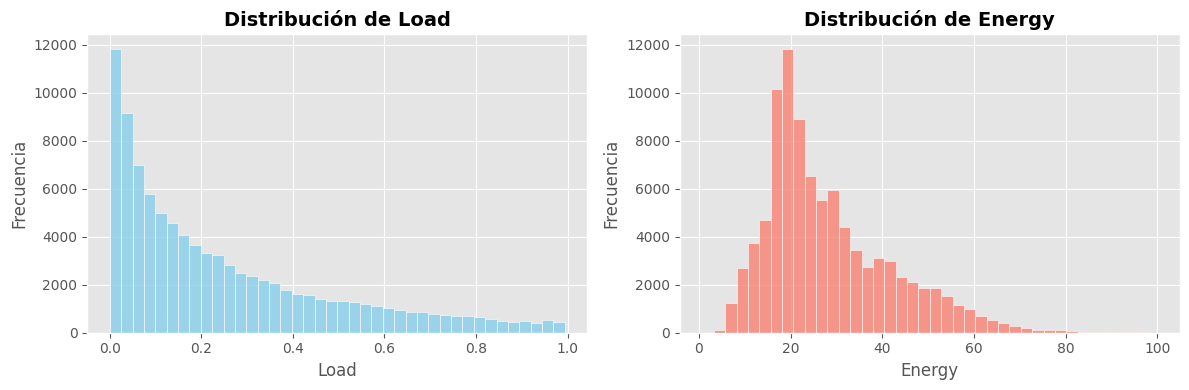

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Histograma de Load
axes[0].hist(df_merge_total['load'], bins=40, color='skyblue', edgecolor='white', alpha=0.8)
axes[0].set_title("Distribución de Load", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Load", fontsize=12)
axes[0].set_ylabel("Frecuencia", fontsize=12)

# Histograma de Energy
axes[1].hist(df_merge_total['Energy'], bins=40, color='salmon', edgecolor='white', alpha=0.8)
axes[1].set_title("Distribución de Energy", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Energy", fontsize=12)
axes[1].set_ylabel("Frecuencia", fontsize=12)

plt.tight_layout()
plt.show()

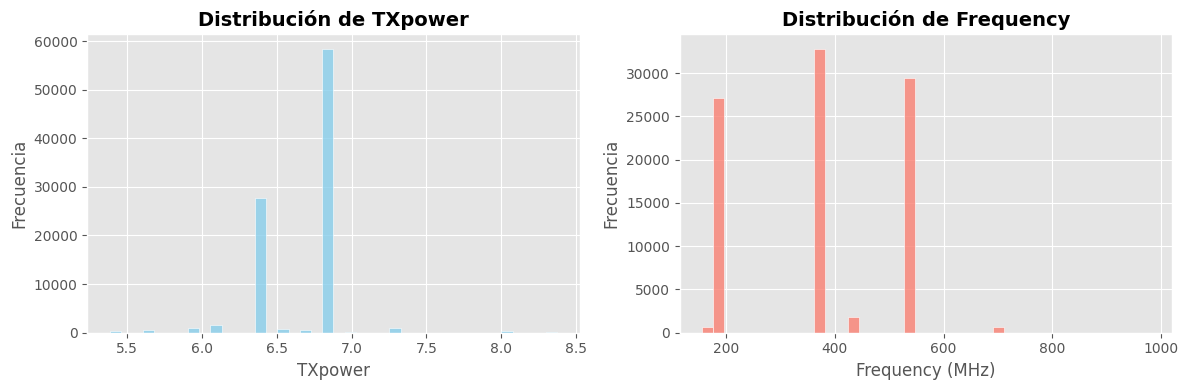

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Histograma de TXpower
axes[0].hist(df_merge_total['TXpower'], bins=40, color='skyblue', edgecolor='white', alpha=0.8)
axes[0].set_title("Distribución de TXpower", fontsize=14, fontweight='bold')
axes[0].set_xlabel("TXpower", fontsize=12)
axes[0].set_ylabel("Frecuencia", fontsize=12)

# Histograma de Frequency
axes[1].hist(df_merge_total['Frequency'], bins=40, color='salmon', edgecolor='white', alpha=0.8)
axes[1].set_title("Distribución de Frequency", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Frequency (MHz)", fontsize=12)
axes[1].set_ylabel("Frecuencia", fontsize=12)

plt.tight_layout()
plt.show()

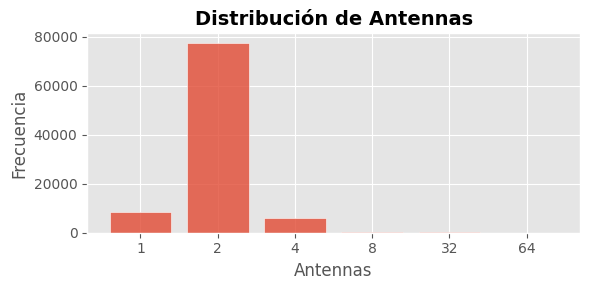

In [19]:
# Calcula conteo de cada valor de Antennas
counts = df_merge_total['Antennas'].value_counts().sort_index()

plt.figure(figsize=(6, 3))
plt.bar(counts.index.astype(str), counts.values, edgecolor='white', alpha=0.8)
plt.title("Distribución de Antennas", fontsize=14, fontweight='bold')
plt.xlabel("Antennas", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)

# Ajusta los ticks del eje X para que solo aparezcan los valores presentes
plt.xticks(counts.index.astype(str))

plt.tight_layout()
plt.show()

### Análisis bivariante

Según la siguiente gráfica, las cargas tienden a agruparse en niveles concretos de frecuencia. Sin embargo, no se observa una relación lineal entre la frecuencia y la carga.

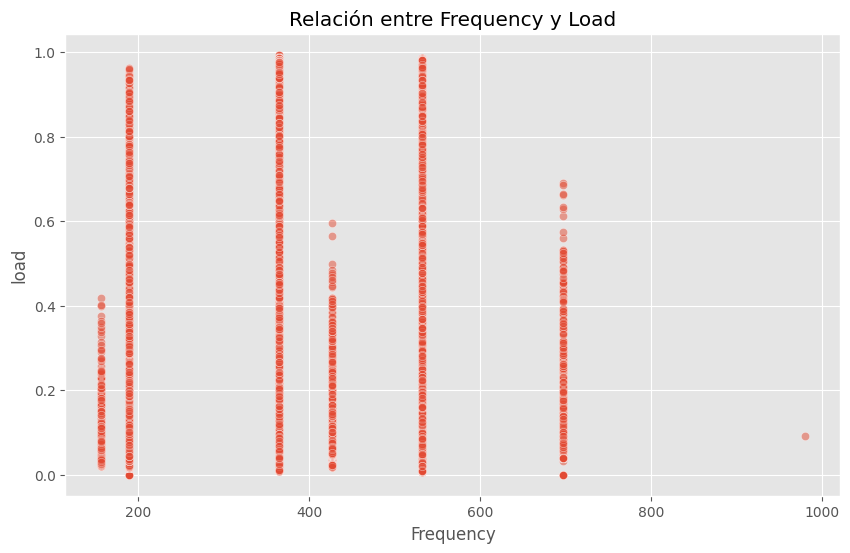

In [20]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_merge_total, x='Frequency', y='load', alpha=0.5)
plt.title('Relación entre Frequency y Load')
plt.show()

En la siguiente gráfica se muestra cómo varía el consumo energético (**Energy**) al aumentar el nivel de carga (**load**). 
Se observa una **clara subida del consumo** conforme la carga crece, lo que confirma que a mayor nivel de tráfico el gasto energético promedio aumenta.


<Axes: xlabel='load'>

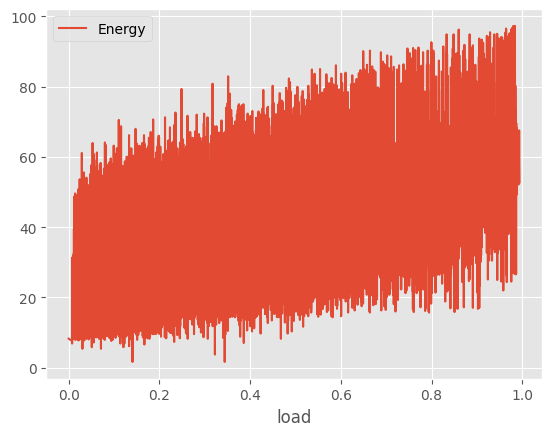

In [22]:
df_merge_total.groupby(['load'])[["Energy"]].mean().plot()

### Correlación

La matriz de correlación evidencia un coeficiente elevado entre el consumo energético (Energy) y el nivel de carga (load), lo que indica una fuerte relación lineal entre ambas variables como he comentado anteriormente.

Energy       1.000000
load         0.668345
Bandwidth    0.341766
TXpower      0.253033
Antennas     0.170925
ESMode3      0.016501
Frequency    0.012707
ESMode6     -0.061041
ESMode2     -0.270284
ESMode1     -0.272003
Name: Energy, dtype: float64


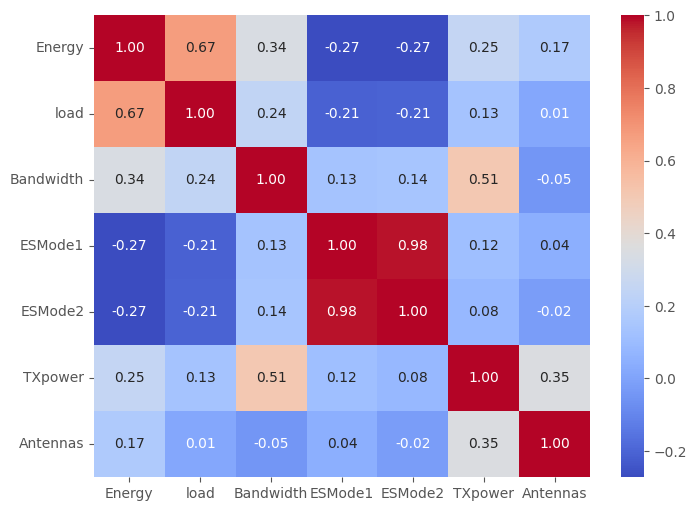

In [23]:
cols_numeric = ['load', 'ESMode1', 'ESMode2', 'ESMode3', 'ESMode6', 'Frequency', 'Bandwidth', 'Antennas', 'TXpower', 'Energy']
corr = df_merge_total[cols_numeric].corr()
print(corr['Energy'].sort_values(ascending=False))  # ordenado por relación con Energy

plt.figure(figsize=(8,6))
sns.heatmap(corr.loc[
      ['Energy'] + corr['Energy'].abs().drop('Energy').nlargest(6).index.tolist(),
      ['Energy'] + corr['Energy'].abs().drop('Energy').nlargest(6).index.tolist()
    ], annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

Relación Load y Energy

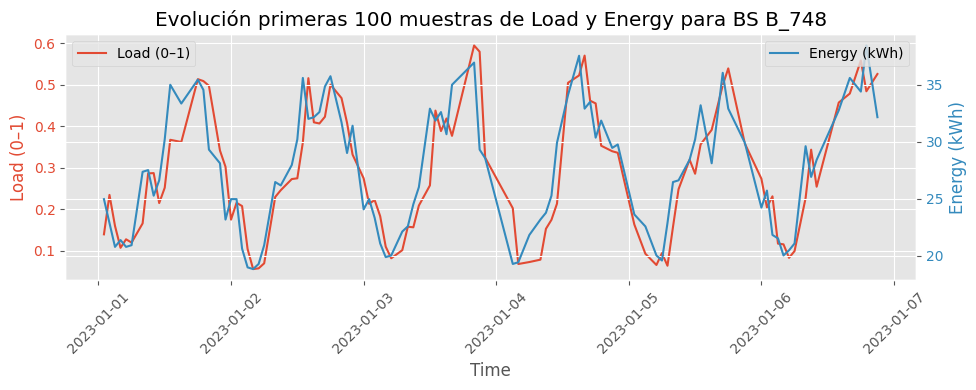

In [24]:
import random

bs_random = random.choice(df_merge_total["BS"].unique().tolist())
df_bs = df_merge_total[df_merge_total["BS"] == bs_random].copy()

df_plot = df_bs.iloc[:100]

fig, ax1 = plt.subplots(figsize=(10, 4))

ax1.plot(df_plot["Time"], df_plot["load"],  color="C0", label="Load (0–1)")
ax1.set_xlabel("Time")
ax1.set_ylabel("Load (0–1)", color="C0")
ax1.tick_params(axis="y", labelcolor="C0")
ax1.tick_params(axis="x", rotation=45)

ax2 = ax1.twinx()
ax2.plot(df_plot["Time"], df_plot["Energy"], color="C1", label="Energy (kWh)")
ax2.set_ylabel("Energy (kWh)", color="C1")
ax2.tick_params(axis="y", labelcolor="C1")

ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.title(f"Evolución primeras 100 muestras de Load y Energy para BS {bs_random}")
plt.tight_layout()
plt.show()

## Feature Engineering

### Generación de variables temporales y cíclicas

En este fragmento se crean nuevas **features** basadas en la columna temporal `Time`:

1. **Componentes de fecha y hora**  
   - `hour`: hora del día (0–23)  
   - `weekday`: día de la semana (0=Lunes … 6=Domingo)  
   - `month`: mes del año (1–12)  
   - `day of year`: día del año (1–365/366)  
2. **Indicador de fin de semana**  
   - `is_weekend`: 1 si el día es sábado o domingo, 0 en caso contrario.  
3. **Codificación cíclica de la hora**  
   Para que los modelos capturen la naturaleza circular de las horas:
   - `sin_hour` = sin(2·π·hour/24)  
   - `cos_hour` = cos(2·π·hour/24)  

In [ ]:
df_merge_total['hour']   = df_merge_total['Time'].dt.hour
df_merge_total['weekday']= df_merge_total['Time'].dt.weekday
df_merge_total['month']  = df_merge_total['Time'].dt.month
df_merge_total['day of year']  = df_merge_total['Time'].dt.dayofyear
df_merge_total['is_weekend']  = (df_merge_total['weekday'] >= 5).astype(int)
df_merge_total['sin_hour'] = np.sin(2*np.pi*df_merge_total['hour']/24)
df_merge_total['cos_hour'] = np.cos(2*np.pi*df_merge_total['hour']/24)

### Generación de métricas derivadas de la carga entre celdas

En este fragmento se crean nuevas **features** que describen la relación entre las cargas de las dos celdas (`load` y `load_1`):

- `load_sum`: suma de las dos cargas.  
- `mult_sum`: producto de las dos cargas.  
- `mean_sum`: media aritmética de las dos cargas.  
- `abs_diff`: diferencia absoluta entre las dos cargas.  
- `max_load`: carga máxima.  
- `min_load`: carga mínima.  
- `std_load`: desviación estándar de las dos cargas.  
- `var_load`: varianza de las dos cargas.  


In [ ]:
df_merge_total["load_sum"] = df_merge_total[["load", "load_1"]].sum(1)
df_merge_total["mult_sum"] = df_merge_total["load"] * df_merge_total["load_1"]
df_merge_total["mean_sum"] = df_merge_total[["load", "load_1"]].mean(axis=1)
df_merge_total["abs_diff"] = (df_merge_total["load"] - df_merge_total["load_1"]).abs()
df_merge_total["max_load"] = df_merge_total[["load","load_1"]].max(axis=1)
df_merge_total["min_load"] = df_merge_total[["load","load_1"]].min(axis=1)

df_merge_total['std_load'] = df_merge_total[['load','load_1']].std(axis=1)
df_merge_total['var_load'] = df_merge_total[['load','load_1']].var(axis=1)

### Codificación ordinal de variables categóricas

En este fragmento de código se aplica un **OrdinalEncoder** para transformar variables categóricas en valores numéricos:

1. Se importa e instancia `OrdinalEncoder` con  
   - `handle_unknown="use_encoded_value"`: asigna un valor fijo a categorías desconocidas.  
   - `unknown_value=-1`: valor que se usará para categorías no vistas durante el ajuste.  
2. Se ajusta (`fit_transform`) el codificador a las columnas `BS`, `Mode` y `RUType` de `df_merge_total`, reemplazándolas por sus códigos ordinales.  

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
df_merge_total[['BS', 'Mode', 'RUType']] = ordinal_encoder.fit_transform(df_merge_total[['BS', 'Mode', 'RUType']])

### Cálculo del ratio de utilización de potencia

En este fragmento se crea una nueva **feature** que mide la eficiencia de la carga respecto a la potencia de transmisión:

- `Power_Utilization_Ratio`: cociente entre la carga (`load`) y la potencia de transmisión (`TXpower`), con un pequeño término `1e-3` para evitar división por cero.  
- `Power_Utilization_Ratio_1`: mismo cociente, pero usando la carga y la potencia de la celda 1 (`load_1` y `TXpower_1`).  


In [ ]:
df_merge_total['Power_Utilization_Ratio'] = df_merge_total['load'] / (df_merge_total['TXpower'] + 1e-3)
df_merge_total['Power_Utilization_Ratio_1'] = df_merge_total['load_1'] / (df_merge_total['TXpower_1'] + 1e-3)

In [29]:
df_merge_total.head()

,Time,BS,Energy,load,ESMode1,ESMode2,ESMode3,ESMode6,same_time_cells,load_1,ESMode1_1,ESMode2_1,ESMode3_1,ESMode6_1,RUType,Mode,Frequency,Bandwidth,Antennas,TXpower,Frequency_1,Bandwidth_1,Antennas_1,TXpower_1,hour,weekday,month,day of year,is_weekend,sin_hour,cos_hour,load_sum,mult_sum,mean_sum,abs_diff,max_load,min_load,std_load,var_load,Power_Utilization_Ratio,Power_Utilization_Ratio_1
0,2023-01-01 01:00:00,0.0,64.275037,0.487936,0.0,0.0,0.0,0.0,1,0.0,-1.0,-1.0,-1.0,-1.0,0.0,1.0,365.0,20,4,6.875934,-1.0,-1.0,-1.0,-1.0,1,6,1,1,1,0.258819,0.965926,0.487936,0.0,0.243968,0.487936,0.487936,0.0,0.345023,0.119041,0.070953,-0.0
1,2023-01-01 02:00:00,0.0,55.904335,0.344468,0.0,0.0,0.0,0.0,1,0.0,-1.0,-1.0,-1.0,-1.0,0.0,1.0,365.0,20,4,6.875934,-1.0,-1.0,-1.0,-1.0,2,6,1,1,1,0.500000,0.866025,0.344468,0.0,0.172234,0.344468,0.344468,0.0,0.243576,0.059329,0.050090,-0.0
2,2023-01-01 03:00:00,0.0,57.698057,0.193766,0.0,0.0,0.0,0.0,1,0.0,-1.0,-1.0,-1.0,-1.0,0.0,1.0,365.0,20,4,6.875934,-1.0,-1.0,-1.0,-1.0,3,6,1,1,1,0.707107,0.707107,0.193766,0.0,0.096883,0.193766,0.193766,0.0,0.137013,0.018773,0.028176,-0.0
3,2023-01-01 04:00:00,0.0,55.156951,0.222383,0.0,0.0,0.0,0.0,1,0.0,-1.0,-1.0,-1.0,-1.0,0.0,1.0,365.0,20,4,6.875934,-1.0,-1.0,-1.0,-1.0,4,6,1,1,1,0.866025,0.500000,0.222383,0.0,0.111191,0.222383,0.222383,0.0,0.157249,0.024727,0.032338,-0.0
4,2023-01-01 05:00:00,0.0,56.053812,0.175436,0.0,0.0,0.0,0.0,1,0.0,-1.0,-1.0,-1.0,-1.0,0.0,1.0,365.0,20,4,6.875934,-1.0,-1.0,-1.0,-1.0,5,6,1,1,1,0.965926,0.258819,0.175436,0.0,0.087718,0.175436,0.175436,0.0,0.124052,0.015389,0.025511,-0.0


## Modelo

La estimación de energía se realizará mediante XGBRegressor.

In [30]:
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
import optuna

Definimos la función de pérdida:

$$
\mathrm{WMAPE} \;=\;
\frac{\displaystyle\sum_{i=1}^{N} w_i \,\bigl|y_i - \hat y_i\bigr|}
     {\displaystyle\sum_{i=1}^{N} w_i \,y_i}
$$

In [31]:
# Función de perdida WMAPE
def wmape(y_true, y_pred, w):
    return np.sum(w * np.abs(y_true - y_pred)) / np.sum(w * np.abs(y_true))

In [32]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

def study_model(X, y, w_val = None):

    def objective(trial):
        params = {
            'tree_method':     'gpu_hist',
            'predictor':       'gpu_predictor',
            'objective':       'reg:gamma',
            'n_estimators':    trial.suggest_int('n_estimators', 500, 3000, step=100),
            'learning_rate':   trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'max_depth':       trial.suggest_int('max_depth', 3, 12),
            'subsample':       trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree':trial.suggest_float('colsample_bytree', 0.3, 1.0),
            'reg_alpha':       trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
            'reg_lambda':      trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
            'random_state':    42,
            'verbosity':       0,
            'n_jobs':         -1
        }
        wmape_scores = []

        for train_idx, val_idx in kf.split(X):
            X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
            if w_val is None:
                w_val_ = np.ones(len(y_val))
            else:
                w_val_ = w_val.iloc[val_idx]
            model = XGBRegressor(**params)
            model.fit(X_tr, y_tr)

            preds = model.predict(X_val)
            wmape_scores.append(wmape(y_val.values, preds, w_val_))

        return np.mean(wmape_scores)
    
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=20, timeout=500)

    print("Mejor MAPE CV encontrado:", study.best_value)
    print("Mejores parámetros:")
    for k, v in study.best_params.items():
        print(f"   • {k}: {v}")
    best_params = study.best_params

    return best_params

### Objetivo A: Desarrollar un modelo capaz de estimar la energía consumida por diferentes productos de estación base.
Desarrollar un modelo que estime la energía consumida por diferentes productos de estación base, teniendo en cuenta el impacto de diversas configuraciones de ingeniería, condiciones de tráfico y métodos de ahorro de energía.

In [33]:
df_trainval = df_merge_total.copy()
mask_valid = df_trainval['Energy'].notnull() & np.isfinite(df_trainval['Energy'])
df_trainval = df_trainval.loc[mask_valid].reset_index(drop=True)

feature_cols = [c for c in df_trainval.columns if c not in ('Energy', 'Time')]

X_A = df_trainval[feature_cols]
y_A = df_trainval['Energy']

In [34]:
best_params = study_model(X_A, y_A)
best_params.update({
    'objective': 'reg:gamma',
    'random_state': 42,
    'verbosity': 0,
    'n_jobs': -1
})

final_model_A = XGBRegressor(**best_params)
final_model_A.fit(X_A, y_A)

[I 2025-07-06 21:21:33,902] A new study created in memory with name: no-name-4e87c121-5508-4cd5-a7b9-5f0200aad201
[I 2025-07-06 21:22:05,566] Trial 0 finished with value: 0.052988382734731755 and parameters: {'n_estimators': 700, 'learning_rate': 0.027658693212242232, 'max_depth': 8, 'subsample': 0.5243651986964997, 'colsample_bytree': 0.8007432137972554, 'reg_alpha': 0.006093543444150808, 'reg_lambda': 1.4298430546323773}. Best is trial 0 with value: 0.052988382734731755.
[I 2025-07-06 21:22:48,011] Trial 1 finished with value: 0.06568186228593767 and parameters: {'n_estimators': 1900, 'learning_rate': 0.03536647339424587, 'max_depth': 5, 'subsample': 0.6190947753542156, 'colsample_bytree': 0.9867317994350973, 'reg_alpha': 8.280244936619887, 'reg_lambda': 0.3218010072584025}. Best is trial 0 with value: 0.052988382734731755.
[I 2025-07-06 21:25:56,087] Trial 2 finished with value: 0.05090957400775592 and parameters: {'n_estimators': 2900, 'learning_rate': 0.14548272335118348, 'max_dep

Mejor MAPE CV encontrado: 0.0502463168626443
Mejores parámetros:
   • n_estimators: 2900
   • learning_rate: 0.05430523006849528
   • max_depth: 12
   • subsample: 0.9939451230090522
   • colsample_bytree: 0.6046814872854184
   • reg_alpha: 9.938508472087015e-06
   • reg_lambda: 1.0604063647408378e-08


,objective,'reg:gamma'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.6046814872854184
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


### Objetivo B: Lograr la capacidad de generalización entre distintos productos de estación base.
El modelo debe estimar el consumo de energía de un nuevo producto de estación base a partir de las mediciones recogidas de otros ya existentes, como los productos A, B y C. Por ejemplo, si se dispone de datos de entrenamiento para estos tres productos, el modelo debe ser capaz de proporcionar una estimación de la energía consumida por el producto D.

In [35]:
df_trainval = df_merge_total.copy()
mask_valid = df_trainval['Energy'].notnull() & np.isfinite(df_trainval['Energy'])
df_trainval = df_trainval.loc[mask_valid].reset_index(drop=True)

bs_all = df_trainval['BS'].unique()
n_bs_val = int(0.2 * len(bs_all))
bs_val = np.random.choice(bs_all, size=n_bs_val, replace=False)

df_trainval['is_val'] = df_trainval['BS'].isin(bs_val)
df_trainval['w'] = 1
df_trainval.loc[df_trainval['is_val'], 'w'] = 5

train_df = df_trainval.loc[~df_trainval['is_val']]
val_df = df_trainval.loc[df_trainval['is_val']]

X_train, y_train = train_df[feature_cols], train_df['Energy']
X_val, y_val = val_df[feature_cols], val_df['Energy']
w_train = train_df['w']
w_val = val_df['w']

In [36]:
best_params = study_model(X_train, y_train, w_train)
best_params.update({
    'objective':    'reg:gamma',
    'random_state': 42,
    'verbosity':    0,
    'n_jobs':      -1
})

final_model_B = XGBRegressor(**best_params)
final_model_B.fit(X_train, y_train)

y_val_pred = final_model_B.predict(X_val)
print("WMAPE sobre BS nuevas:", wmape(y_val.values, y_val_pred, w_val.values))


[I 2025-07-06 21:34:02,634] A new study created in memory with name: no-name-436ffd72-6c4a-4b50-8afc-0f7a3e314c00
[I 2025-07-06 21:34:43,261] Trial 0 finished with value: 0.05047143172571772 and parameters: {'n_estimators': 1300, 'learning_rate': 0.11599065771455547, 'max_depth': 8, 'subsample': 0.5168269240122155, 'colsample_bytree': 0.6404356059414273, 'reg_alpha': 0.20059403264847306, 'reg_lambda': 2.7787757348421335e-07}. Best is trial 0 with value: 0.05047143172571772.
[I 2025-07-06 21:35:17,432] Trial 1 finished with value: 0.054350731872403094 and parameters: {'n_estimators': 2800, 'learning_rate': 0.024743271054569138, 'max_depth': 5, 'subsample': 0.8607044509386779, 'colsample_bytree': 0.6110620715601378, 'reg_alpha': 0.3914904909770039, 'reg_lambda': 0.0015743453461226208}. Best is trial 0 with value: 0.05047143172571772.
[I 2025-07-06 21:35:55,663] Trial 2 finished with value: 0.049540280469394266 and parameters: {'n_estimators': 2300, 'learning_rate': 0.09595462435949735, '

Mejor MAPE CV encontrado: 0.046419458610960605
Mejores parámetros:
   • n_estimators: 1800
   • learning_rate: 0.031623889319693045
   • max_depth: 8
   • subsample: 0.9641900739221198
   • colsample_bytree: 0.8363419532733327
   • reg_alpha: 2.5043237267202414e-08
   • reg_lambda: 0.19489508468691913
WMAPE sobre BS nuevas: 0.09426884944265146


### Objetivo C: Alcanzar capacidades de generalización a través de diferentes configuraciones de estaciones base.
El modelo debe predecir el consumo de energía de los parámetros recién configurados basándose en un pequeño número de parámetros reales de configuración de la red. Por ejemplo, si los datos de entrenamiento contienen muestras recogidas de muchos productos de estaciones base, cuando la potencia de transmisión se establece en 30, 35 y 43 dBm, el modelo debe estimar la energía consumida cuando la potencia de transmisión se establece en 40 dBm.

In [37]:
df = df_merge_total.copy()
mask_valid = df['Energy'].notnull() & np.isfinite(df['Energy'])
df = df.loc[mask_valid].reset_index(drop=True)

bs_all      = df['BS'].unique()
rutype_all  = df['RUType'].unique()

n_bs_val     = int(0.2 * len(bs_all))
n_rut_val    = max(1, int(0.2 * len(rutype_all)))  

bs_val       = np.random.choice(bs_all,    size=n_bs_val,    replace=False)
rutype_val   = np.random.choice(rutype_all,size=n_rut_val,    replace=False)

df['is_val'] = df['BS'].isin(bs_val) | df['RUType'].isin(rutype_val)
df['w']      = 1
df.loc[df['BS'].isin(bs_val), 'w'] = 10

feature_cols = [c for c in df.columns if c not in ('Energy','Time','is_val','w')]
train_df = df.loc[~df['is_val']]
val_df   = df.loc[ df['is_val']]


X_train = train_df[feature_cols]
y_train = train_df['Energy']
X_val   = val_df[feature_cols]
y_val   = val_df['Energy']
w_train   = train_df['w']
w_val   = val_df['w']

In [38]:
best_params = study_model(X_train, y_train, w_train)
best_params.update({
    'objective':    'reg:gamma',
    'random_state': 42,
    'verbosity':    0,
    'n_jobs':      -1
})

final_model_C = XGBRegressor(**best_params)
final_model_C.fit(X_train, y_train)

y_val_pred = final_model_C.predict(X_val)
print("WMAPE sobre BS y RUType nuevos:", wmape(y_val.values, y_val_pred, w_val.values))


[I 2025-07-06 21:44:13,517] A new study created in memory with name: no-name-4955b636-68d5-41bf-bd04-6ddeb2ca7b86
[I 2025-07-06 21:47:12,645] Trial 0 finished with value: 0.04911836964365006 and parameters: {'n_estimators': 2400, 'learning_rate': 0.1251070284686705, 'max_depth': 12, 'subsample': 0.8645551326057388, 'colsample_bytree': 0.6945886537173984, 'reg_alpha': 4.37188511113967e-06, 'reg_lambda': 0.0001523886755577729}. Best is trial 0 with value: 0.04911836964365006.
[I 2025-07-06 21:48:02,028] Trial 1 finished with value: 0.04669810020317981 and parameters: {'n_estimators': 2900, 'learning_rate': 0.03251935084769898, 'max_depth': 6, 'subsample': 0.7824198079759319, 'colsample_bytree': 0.7252793134274373, 'reg_alpha': 0.019946776584574864, 'reg_lambda': 0.00031077030302939567}. Best is trial 1 with value: 0.04669810020317981.
[I 2025-07-06 21:49:38,149] Trial 2 finished with value: 0.044915785043428004 and parameters: {'n_estimators': 2000, 'learning_rate': 0.02208636045607516, 

Mejor MAPE CV encontrado: 0.044915785043428004
Mejores parámetros:
   • n_estimators: 2000
   • learning_rate: 0.02208636045607516
   • max_depth: 9
   • subsample: 0.9255801729748152
   • colsample_bytree: 0.8894079120267286
   • reg_alpha: 0.028869581207342784
   • reg_lambda: 8.609256953375357e-06
WMAPE sobre BS y RUType nuevos: 0.11293925523114648


| Modelo   | WMAPE | W |
|----------|:-----:|:-:|
| Model_A  |   0.05    |  1  |
| Model_B  |   0.094    |  5  |
| Model_C  |   0.11     |  10 |
